In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
df=pd.read_csv(r"C:\Users\rajan\Downloads\occupancy_data\datatraining.txt")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (8143, 7)


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.1800,27.2720,426.0000,721.2500,0.0048,1
2,2015-02-04 17:51:59,23.1500,27.2675,429.5000,714.0000,0.0048,1
3,2015-02-04 17:53:00,23.1500,27.2450,426.0000,713.5000,0.0048,1
4,2015-02-04 17:54:00,23.1500,27.2000,426.0000,708.2500,0.0048,1
5,2015-02-04 17:55:00,23.1000,27.2000,426.0000,704.5000,0.0048,1


In [16]:
main_data=df.iloc[:, 1:7]
main_data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.1800,27.2720,426.0000,721.2500,0.0048,1
2,23.1500,27.2675,429.5000,714.0000,0.0048,1
3,23.1500,27.2450,426.0000,713.5000,0.0048,1
4,23.1500,27.2000,426.0000,708.2500,0.0048,1
5,23.1000,27.2000,426.0000,704.5000,0.0048,1
...,...,...,...,...,...,...
8139,21.0500,36.0975,433.0000,787.2500,0.0056,1
8140,21.0500,35.9950,433.0000,789.5000,0.0056,1
8141,21.1000,36.0950,433.0000,798.5000,0.0056,1
8142,21.1000,36.2600,433.0000,820.3333,0.0056,1


In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(main_data)

In [19]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
# create dataset
X, y = dataset,df['Occupancy']
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4071, 6) (4072, 6) (4071,) (4072,)


In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=METRICS)

history = model.fit(X_train, y_train, epochs=30, batch_size=70, validation_data=(X_test, y_test), verbose=1)

model.summary()

Epoch 1/30
59/59 [==============================] - 7s 35ms/step - loss: 0.6146 - tp: 29.0000 - fp: 18.0000 - tn: 3234.0000 - fn: 790.0000 - accuracy: 0.8015 - precision: 0.6170 - recall: 0.0354 - auc: 0.7730 - prc: 0.4028 - val_loss: 0.5275 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 3162.0000 - val_fn: 900.0000 - val_accuracy: 0.7790 - val_precision: 1.0000 - val_recall: 0.0110 - val_auc: 0.9990 - val_prc: 0.9959
Epoch 2/30
59/59 [==============================] - 1s 9ms/step - loss: 0.4153 - tp: 278.0000 - fp: 0.0000e+00 - tn: 3252.0000 - fn: 541.0000 - accuracy: 0.8671 - precision: 1.0000 - recall: 0.3394 - auc: 0.9991 - prc: 0.9968 - val_loss: 0.3099 - val_tp: 865.0000 - val_fp: 0.0000e+00 - val_tn: 3162.0000 - val_fn: 45.0000 - val_accuracy: 0.9889 - val_precision: 1.0000 - val_recall: 0.9505 - val_auc: 1.0000 - val_prc: 0.9999
Epoch 3/30
59/59 [==============================] - 0s 7ms/step - loss: 0.2084 - tp: 804.0000 - fp: 0.0000e+00 - tn: 3252.0000 - fn: 15.0000 - accura

59/59 [==============================] - 0s 8ms/step - loss: 0.0012 - tp: 819.0000 - fp: 0.0000e+00 - tn: 3252.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0017 - val_tp: 910.0000 - val_fp: 2.0000 - val_tn: 3160.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9995 - val_precision: 0.9978 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 21/30
59/59 [==============================] - 0s 8ms/step - loss: 0.0011 - tp: 819.0000 - fp: 0.0000e+00 - tn: 3252.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0016 - val_tp: 910.0000 - val_fp: 2.0000 - val_tn: 3160.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9995 - val_precision: 0.9978 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 22/30
59/59 [==============================] - 0s 8ms/step - loss: 9.6459e-04 - tp: 819.0000 - fp: 0.0000e+00 - tn: 3252.0000 - fn: 0.0000e+00 - acc

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape

128/128 [==============================] - 0s 2ms/step


(4071, 1)

In [24]:
loss,tp,fp,tn,fn,accuracy,precision, recall,auc,prc = model.evaluate(X_test, y_test, verbose=0)

In [25]:
loss

0.0010076049948111176

In [26]:
tp,fp,tn,fn,accuracy,precision,recall,auc,prc

(910.0,
 2.0,
 3160.0,
 0.0,
 0.9995088577270508,
 0.9978070259094238,
 1.0,
 1.0,
 1.0)

In [27]:
precision

0.9978070259094238

In [28]:
recall

1.0

In [29]:
f1score=(2*precision*recall)/(precision+recall)
f1score

0.9989023093511357

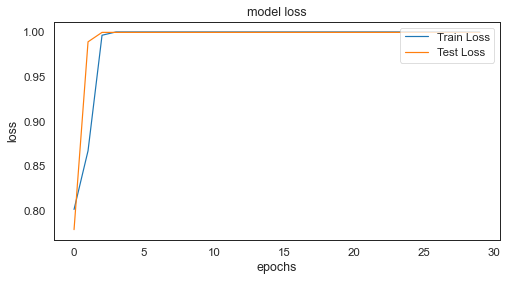

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [32]:
y_test

2668    1
2528    1
2312    1
1604    0
7241    0
       ..
8097    1
2132    0
2501    1
3489    0
414     0
Name: Occupancy, Length: 4072, dtype: int64

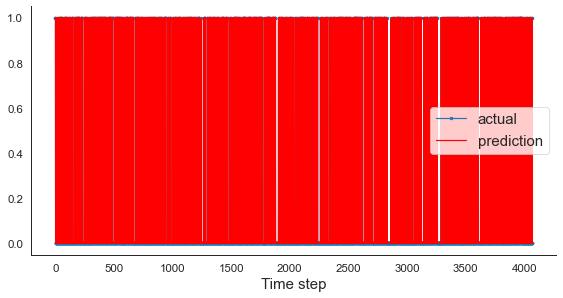

In [43]:
aa=[x for x in range(4072)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[:4072], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:23492], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [34]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [35]:
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [36]:
pred=clf.predict(X)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
score=accuracy_score(y,pred)

In [39]:
score

1.0